In [24]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef, classification_report
from sklearn.metrics import cohen_kappa_score, precision_recall_fscore_support
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
nlp = spacy.load("en_core_web_lg")

/usr/local/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_lg' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [25]:
def learning_curves_display(data_choice, vect_choice, classifiers, X, y, ylim=(0.5, 1.01), cv=None, n_jobs=None, 
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    
    size = len(classifiers)
    for clf in classifiers:
        if data_choice == "complete":
            ylim = (0.1, 1.01)
        else:
            ylim = (0.1, 1.01)
        plot_learning_curve(data_choice, vect_choice, clf, X, y, ylim, cv, n_jobs, train_sizes)

In [26]:
def metrics_display(data_choice, vect_choice, classifiers, X, y):
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, shuffle=True)
    
    results = {}
    for clf in classifiers:
        clf_name = type(clf).__name__
        results[clf_name] = calc_metrics(data_choice, vect_choice, clf, X_train, y_train, X_valid, y_valid)
    return results

In [27]:
def calc_metrics(data_choice, vect_choice, clf, X_train, y_train, X_valid, y_valid):
    figsize = ()
    if data_choice == "complete":
        figsize=(15, 12)
    else:
        figsize=(10, 6)
    
    fig, axes = plt.subplots(figsize=figsize)
    
    clf_name = type(clf).__name__
    axes.set_title(f'{clf_name}, {data_choice.capitalize()} dataset, {vect_choice.capitalize()}')
    results = {}

    print(f"Started training: {clf_name}")

    clf.fit(X_train, y_train)

    print(f"Finished training: {clf_name}")

    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_valid)

    cm = ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
    
    axes.xaxis.label.set_color('white')
    axes.yaxis.label.set_color('white')
    axes.title.set_color('white')
    axes.tick_params(axis='x', colors='white')
    axes.tick_params(axis='y', colors='white')
    
    cm.plot(ax=axes)
    results["accuracy"] = balanced_accuracy_score(y_valid, y_pred)

    all_scores = precision_recall_fscore_support(y_valid, y_pred, pos_label="positive", average="weighted")#macro, micro or weighted?
    results["precision"] = all_scores[0] 
    results["recall"] = all_scores[1] 
    results["f1"] = all_scores[2] 
    results["support"] = all_scores[3] 

    #results[clf_name]["roc"] = roc_auc_score(y_test, y_pred)
    results["matthew_coeff"] = matthews_corrcoef(y_valid, y_pred)
    results["cohen_kappa"] = cohen_kappa_score(y_valid, y_pred)   
    
    #fig.patch.set_facecolor('white')
    plt.tight_layout()
    fig.savefig(f'confusion_matrix_{clf_name}_{data_choice}_{vect_choice}.png')   
    print(f'Saved to confusion_matrix_{clf_name}_{data_choice}_{vect_choice}.png')
    
    
    return results

In [28]:
def plot_learning_curve(data_choice, vect_choice, clf, X, y, ylim=(0.5, 1.01), cv=None, n_jobs=None, 
                        train_sizes=np.linspace(0.1, 1.0, 5)):

    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    clf_name = type(clf).__name__
    ax.set_title(f"{clf_name}, {data_choice.capitalize()} dataset, {vect_choice.capitalize()}")
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)                                                                                                           

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    ax.legend(loc="best")

    
    
    fig.savefig(f'learning_curve_{clf_name}_{data_choice}_{vect_choice}.png')
    print(f'Saved to learning_curve_{clf_name}_{data_choice}_{vect_choice}.png')
    plt.show()

In [29]:
def get_binary_df():
    return pd.read_csv("tweet_emotions_binary_cleaned.csv")

def get_ternary_df():
    return pd.read_csv("tweet_emotions_three_classes_cleaned.csv")

def get_complete_df():
    return pd.read_csv("tweet_emotions_cleaned.csv")

In [30]:
def get_spacy_embedding(df, X_train, X_test):
    X_train = [nlp(text).vector for text in X_train]
    X_test = [nlp(text).vector for text in X_test]
    
    return X_train, X_test

In [32]:
def train_models(classifiers, data_choice="binary", vect_choice="tfidf", text="text", labels="sentiment"):
    df = None
    if data_choice == "binary":
        df = get_binary_df()
    elif data_choice == "ternary":
        df = get_ternary_df()
    elif data_choice == "complete":
        df = get_complete_df()
        labels = "sentiment"
    else:
        df = get_binary_df()
    
    df = remove_empty_rows(df)
    
    X = None
    if vect_choice == "tfidf":
        vectorizer = TfidfVectorizer()
        vectorizer.fit(df["cleaned_content"])
        X = vectorizer.transform(df[text])
        print("Amount of features: ", len(vectorizer.get_feature_names_out()))
        print("Features: ", vectorizer.get_feature_names_out())
    elif vect_choice == "spacy":
        X = [nlp(text).vector for text in df["cleaned_content"]]
    
    y = df[labels]

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    learning_curves_display(data_choice, vect_choice, classifiers, X, y, cv=cv, n_jobs=4)
    
    results = metrics_display(data_choice, vect_choice, classifiers, X, y)
    
    df_results = pd.DataFrame(results)
    
    plt.show()
    
    return df_results

    

In [33]:
def create_bar_plot(data_choice, vect_choice, score_type):
    df = pd.read_csv(f"{data_choice}_{vect_choice}_results_raw.csv", index_col=0)
    clf_names = df.columns
    scores = df.loc[score_type] 
    fig, ax = plt.subplots(figsize=(3 * len(clf_names), 4))
    
    ax.set(ylim=(min(scores)-0.05, max(scores)+0.05))
    
    ax.set_title(f'{score_type.capitalize()} comparison, {data_choice.capitalize()} dataset, {vect_choice.capitalize()}')
    p1 = ax.bar(clf_names, scores, color ='navy', width = 0.2)
    ax.bar_label(p1, padding=5)

    ax.set_xlabel('Classifiers')
    ax.set_ylabel(f'{score_type.capitalize()} Scores')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    #fig.patch.set_facecolor('white')
    fig.savefig(f'{score_type}_scores_comparison_{data_choice}_{vect_choice}.png')
    print(f'Saved to {score_type}_scores_comparison_{data_choice}_{vect_choice}.png')
    fig.tight_layout()
    plt.show()

In [34]:
def remove_empty_rows(df, text="cleaned_content", labels="sentiment"):
    df[text].replace("", np.nan, inplace=True)
    df.dropna(subset=[text], inplace=True)
    df[labels].replace("", np.nan, inplace=True)
    df.dropna(subset=[labels], inplace=True)
    return df

Amount of features:  25247
Features:  ['a_mccallie' 'aa' 'aaa' ... 'ï½ï½' 'ï½ï½l' 'ï½ï½we']
Saved to learning_curve_MLPClassifier_binary_tfidf.png


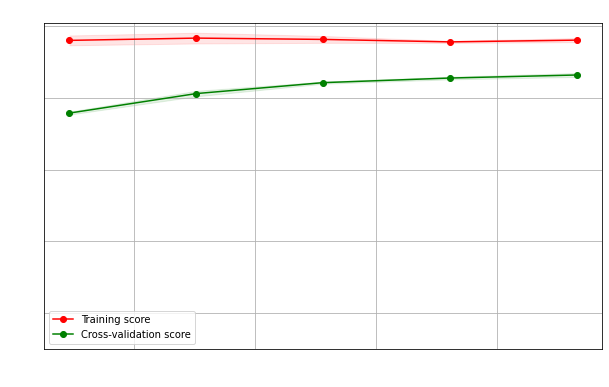

Started training: MLPClassifier
Finished training: MLPClassifier


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Saved to confusion_matrix_MLPClassifier_binary_tfidf.png


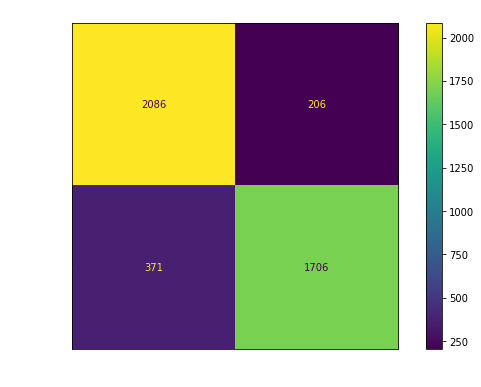

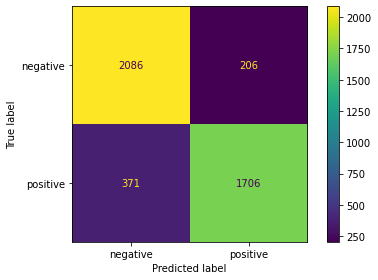

Saved to f1_scores_comparison_binary_tfidf.png


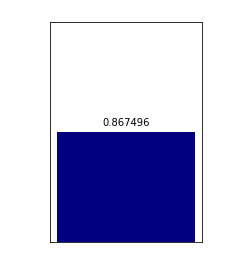

Saved to accuracy_scores_comparison_binary_tfidf.png


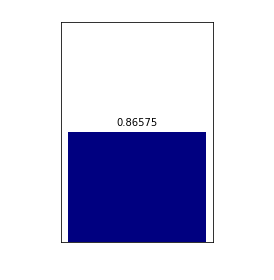

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Saved to learning_curve_MLPClassifier_binary_spacy.png


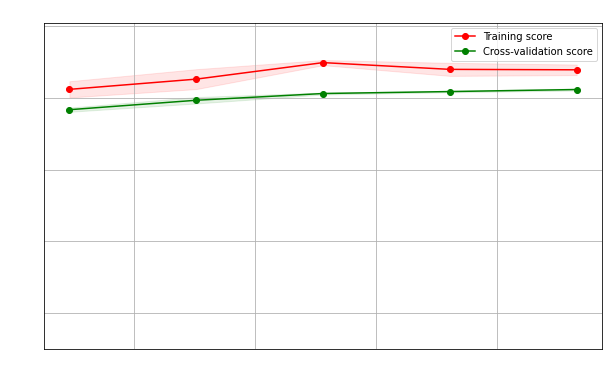

Started training: MLPClassifier
Finished training: MLPClassifier


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Saved to confusion_matrix_MLPClassifier_binary_spacy.png


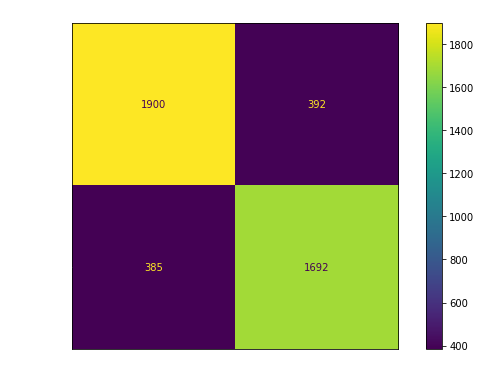

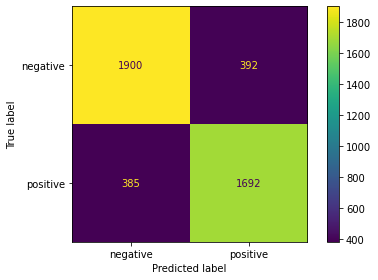

Saved to f1_scores_comparison_binary_spacy.png


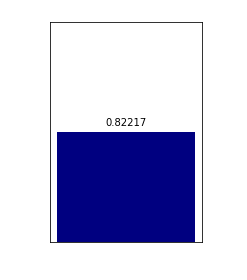

Saved to accuracy_scores_comparison_binary_spacy.png


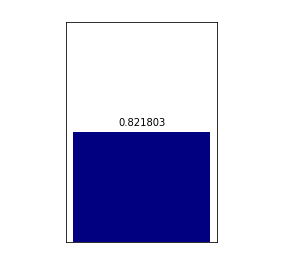

Amount of features:  29761
Features:  ['a_mccallie' 'aa' 'aaa' ... 'ï½ï½l' 'ï½ï½we' 'ï½ï½ï½ï½']
Saved to learning_curve_MLPClassifier_ternary_tfidf.png


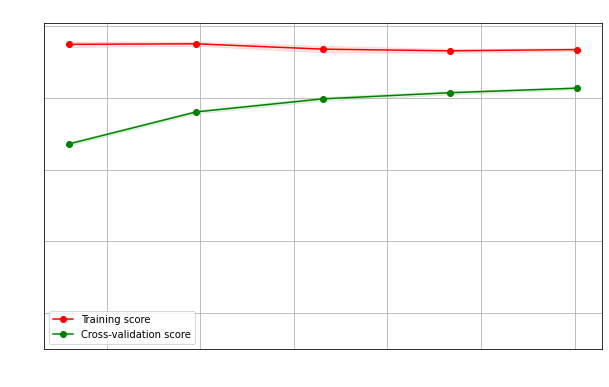

Started training: MLPClassifier
Finished training: MLPClassifier


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Saved to confusion_matrix_MLPClassifier_ternary_tfidf.png


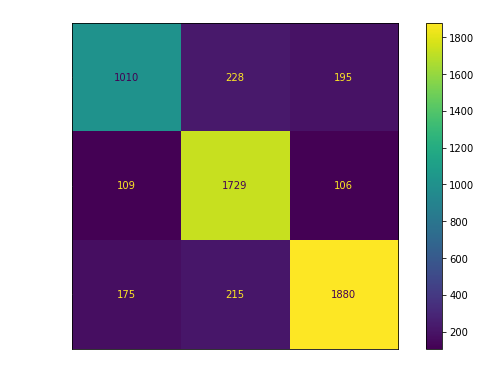

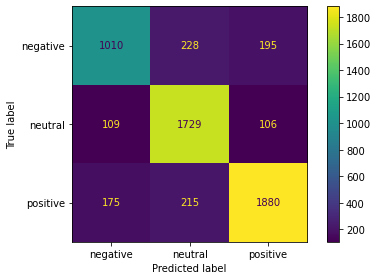

Saved to f1_scores_comparison_ternary_tfidf.png


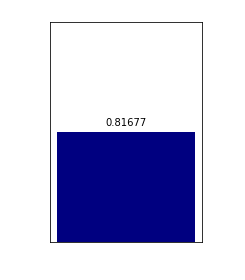

Saved to accuracy_scores_comparison_ternary_tfidf.png


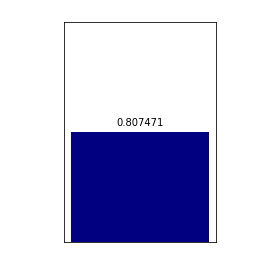

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Saved to learning_curve_MLPClassifier_ternary_spacy.png


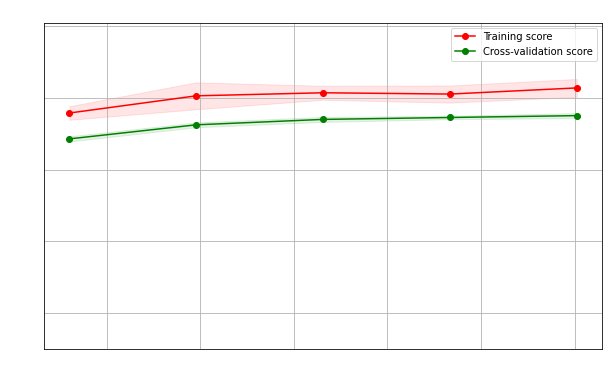

Started training: MLPClassifier
Finished training: MLPClassifier


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Saved to confusion_matrix_MLPClassifier_ternary_spacy.png


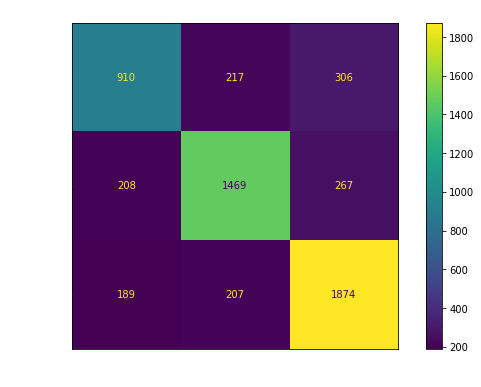

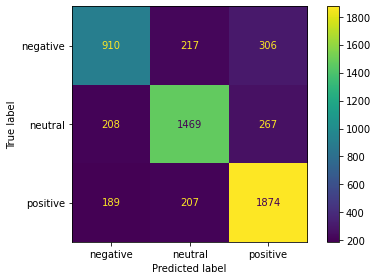

Saved to f1_scores_comparison_ternary_spacy.png


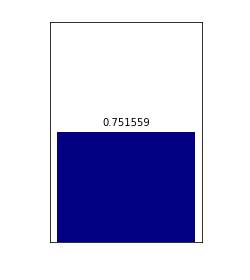

Saved to accuracy_scores_comparison_ternary_spacy.png


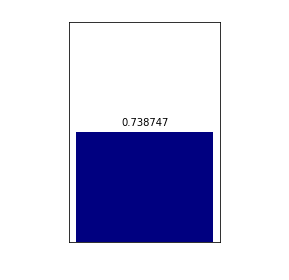

Amount of features:  30992
Features:  ['a_mccallie' 'aa' 'aaa' ... 'ï½ï½l' 'ï½ï½we' 'ï½ï½ï½ï½']
Saved to learning_curve_MLPClassifier_complete_tfidf.png


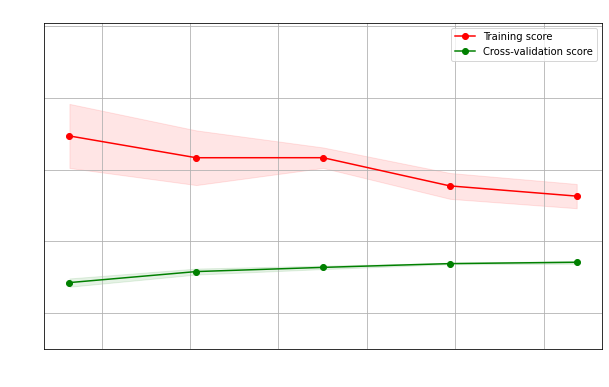

Started training: MLPClassifier
Finished training: MLPClassifier


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saved to confusion_matrix_MLPClassifier_complete_tfidf.png


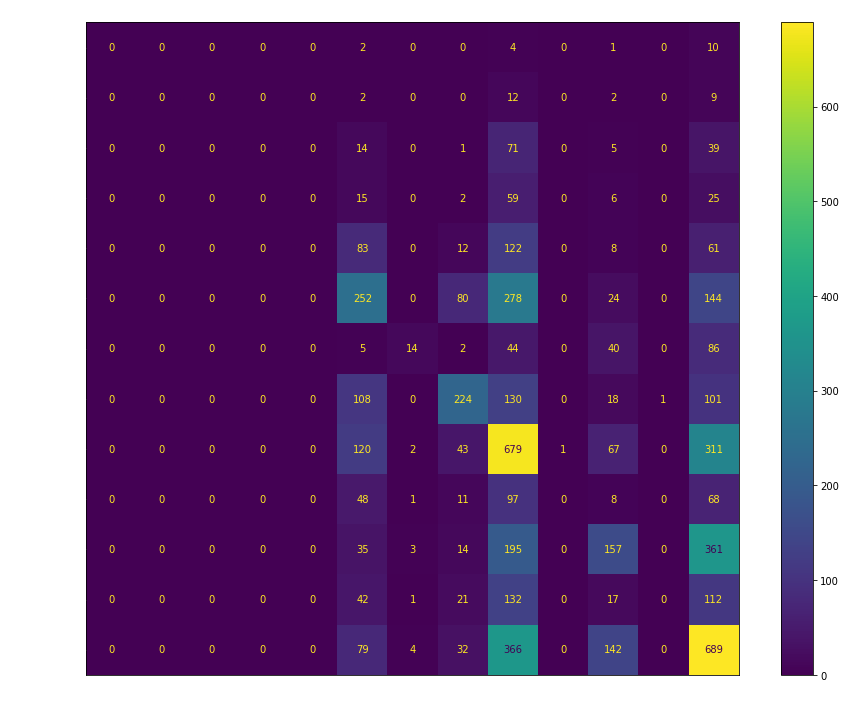

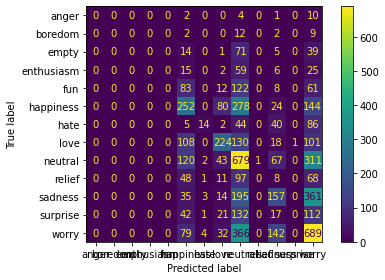

Saved to f1_scores_comparison_complete_tfidf.png


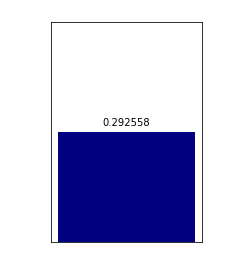

Saved to accuracy_scores_comparison_complete_tfidf.png


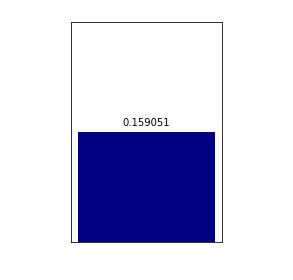

Saved to learning_curve_MLPClassifier_complete_spacy.png


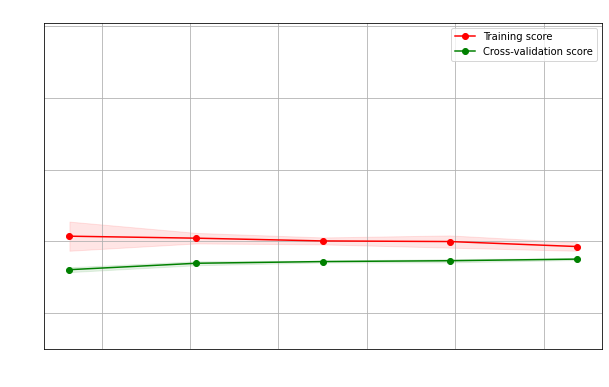

Started training: MLPClassifier
Finished training: MLPClassifier


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saved to confusion_matrix_MLPClassifier_complete_spacy.png


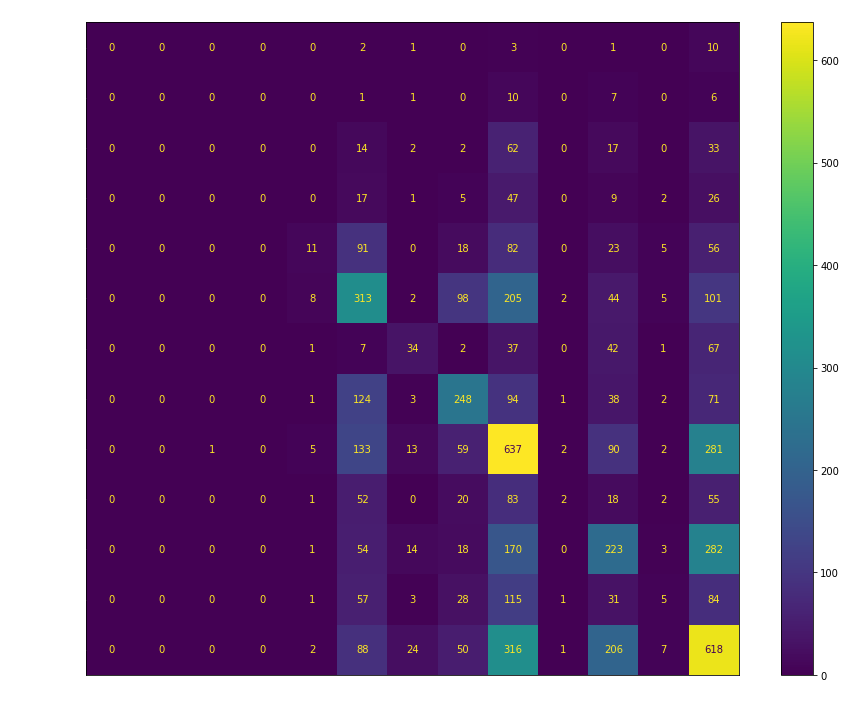

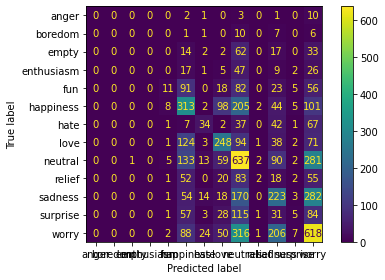

Saved to f1_scores_comparison_complete_spacy.png


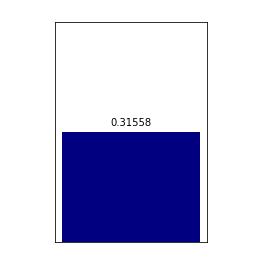

Saved to accuracy_scores_comparison_complete_spacy.png


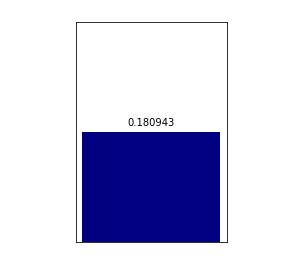

In [36]:
#classifiers = [svm.LinearSVC(), RandomForestClassifier(), MLPClassifier(max_iter=50)]
classifiers = [MLPClassifier(max_iter=50, early_stopping=True)]
#data_choice = "complete"
data_choices = ["binary", "ternary","complete"]
vect_choices = ["tfidf", "spacy"]

for data_choice in data_choices:
    for vect_choice in vect_choices:
        df_results = train_models(classifiers, data_choice, vect_choice, text="cleaned_content", labels="new_sentiment")
        df_results.to_csv(f"{data_choice}_{vect_choice}_results_raw.csv")
        create_bar_plot(data_choice, vect_choice, "f1")
        create_bar_plot(data_choice, vect_choice, "accuracy")


In [37]:
df_results.head(10)

,MLPClassifier
accuracy,0.180943
cohen_kappa,0.214224
f1,0.315580
matthew_coeff,0.217537
precision,0.320118
recall,0.350017
support,NaN


In [ ]:
#classifiers = [svm.LinearSVC(), RandomForestClassifier(), MLPClassifier(max_iter=50)]
classifiers = [MLPClassifier(max_iter=50)]
#data_choice = "complete"
data_choices = ["binary", "ternary","complete"]
vect_choices = ["tfidf", "spacy"]

for data_choice in data_choices:
    for vect_choice in vect_choices:
        df_results = train_models(classifiers, data_choice, vect_choice, text="cleaned_content", labels="new_sentiment")
        df_results.to_csv(f"{data_choice}_{vect_choice}_results_raw.csv")
        create_bar_plot(data_choice, vect_choice, "f1")
        create_bar_plot(data_choice, vect_choice, "accuracy")


In [ ]:
df_results.head(10)